In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Lambda
from tqdm import tqdm

from dataset import GTA
from parameters import *
from models import *

In [21]:
print(device)

cuda


In [22]:
scaling_factor = 2
crop_size = 96*scaling_factor
large_kernel_size = 9
small_kernel_size = 3
n_channels = 64
n_blocks = 16
lr_img_type = '[0, 1]'#'gta-small-norm'#
hr_img_type = '[0, 1]'#'[-1, 1]'

batch_size = 8
epochs = 5
lr = 1e-4
#grad_clip = None

train_path = 'data/GTAV/small/'
training_data = GTA(train_path,'train',crop_size, scaling_factor,lr_img_type,hr_img_type)
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

In [23]:
criterion = nn.MSELoss().to(device)
#checkpoint = 'checkpoint_srresnet.pth.tar'
checkpoint = None
if checkpoint is not None:
    checkpoint = torch.load(checkpoint)
    start_epoch = checkpoint['epoch'] + 1
    model = checkpoint['model']
    optimizer = checkpoint['optimizer']
else:
    model = SRResNet(large_kernel_size,small_kernel_size, n_channels, n_blocks, scaling_factor).to(device)
    optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, model.parameters()),lr=lr)
    start_epoch = 0

In [24]:
losses = []

for epoch in range(epochs):
    print("EPOCH",epoch+start_epoch+1)
    running_loss = 0
    print_freq = 20
    loop = tqdm(train_dataloader, desc=f"Epoch {epoch+1+start_epoch}/{epochs+start_epoch}")
    for i,(lr_imgs, hr_imgs) in enumerate(loop):
        lr_imgs = lr_imgs.to(device)
        hr_imgs = hr_imgs.to(device)

        sr_imgs = model(lr_imgs)

        loss = criterion(sr_imgs, hr_imgs)

        optimizer.zero_grad()
        loss.backward()

        # # Clip gradients, if necessary
        # if grad_clip is not None:
        #     clip_gradient(optimizer, grad_clip)

        optimizer.step()
        running_loss += loss.item()
        if i % print_freq==print_freq-1:
            current_loss = running_loss / print_freq
            losses.append(current_loss)
            running_loss = 0

            loop.set_postfix(loss=current_loss)

    torch.save({'epoch': epoch+start_epoch,
                    'model': model,
                    'optimizer': optimizer},
                   'checkpoint_srresnet_[01].pth.tar')

EPOCH 1


Epoch 1/5: 100%|██████████| 313/313 [00:31<00:00,  9.79it/s, loss=0.00355]


EPOCH 2


Epoch 2/5: 100%|██████████| 313/313 [00:30<00:00, 10.32it/s, loss=0.00283]


EPOCH 3


Epoch 3/5: 100%|██████████| 313/313 [00:30<00:00, 10.17it/s, loss=0.00201]


EPOCH 4


Epoch 4/5: 100%|██████████| 313/313 [00:30<00:00, 10.22it/s, loss=0.00144]


EPOCH 5


Epoch 5/5: 100%|██████████| 313/313 [00:30<00:00, 10.40it/s, loss=0.00189]


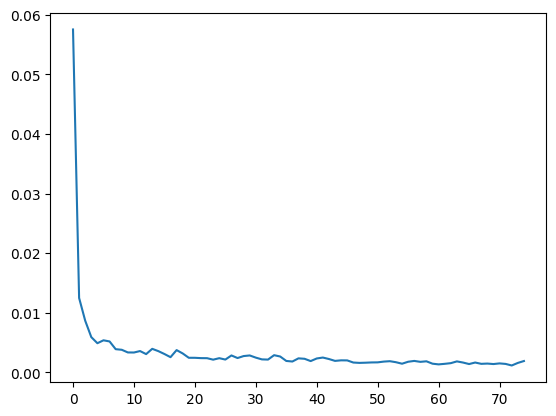

In [25]:
plt.plot(losses)
plt.show()

C:\Users\Robert\AppData\Local\Temp\ipykernel_21000\3034193142.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoint_srresnet_.pth.tar')


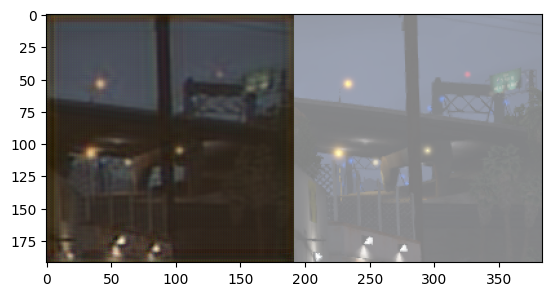

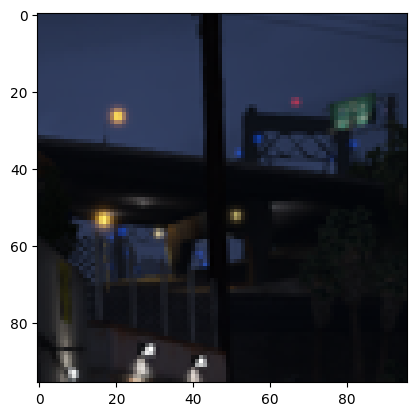

In [26]:
from srresnet import _NetD

checkpoint = torch.load('checkpoint_srresnet_.pth.tar')
model = checkpoint['model']
#model = SRResNet(large_kernel_size,small_kernel_size, n_channels, n_blocks, scaling_factor)

with torch.no_grad():
    for lr_img, hr_img in training_data:
        model.eval()
        sr_img = model(lr_img.unsqueeze(0)).to('cpu').squeeze(0).permute(1, 2, 0).numpy()
        sr_img = (sr_img+1)/2
        sr_img = (sr_img - np.min(sr_img)) / (np.max(sr_img) - np.min(sr_img))
        plt.imshow(np.concatenate([sr_img, ((hr_img+1)/2).permute(1, 2, 0).numpy()], axis=1))
        plt.show()
        plt.imshow(((lr_img-torch.min(lr_img))/(torch.max(lr_img)-torch.min(lr_img))).permute(1, 2, 0).numpy())
        plt.show()
        break